<a href="https://colab.research.google.com/github/DiGyt/neuropynamics/blob/DiGyt_dev/notebooks/bifurcation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install brian2

     |████████████████████████████████| 1.6MB 9.0MB/s 
     |████████████████████████████████| 5.8MB 53.9MB/s 
  Created wheel for brian2: filename=Brian2-2.3.0.2-cp36-cp36m-linux_x86_64.whl size=1283473 sha256=4cbd2487aa3ffe5e5c8675aa45df59619add34b5e00d06dd510dc057e0c8e3ff
  Stored in directory: /root/.cache/pip/wheels/86/b5/f6/0c8f9eec58c01e4af55a4c79a5e0385aea01ed03e4ec36c4ac
Successfully built brian2
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1


In [2]:
from brian2 import *
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox, FloatSlider
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/setuptools/distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "


## Examine Bifurcation processes for Neurons

## Try to create neuron models converting the brian stuff to sympy

In [ ]:
import sympy

In [ ]:
from sympy.parsing.sympy_parser import parse_expr
from sympy.parsing.sympy_parser import standard_transformations, implicit_multiplication_application


class Neuron():

  def __init__(self, differential, threshold, reset):

    self.differential = differential
    self.threshold = threshold
    self.reset = reset


  def _string_to_func(self, equation_str):
    return parse_expr(equation_str, transformations=PARSE_TRANSFORM)

def AdEx():
  """Creates an adaptive exponential integrate-and-fire neuron (Brette-Gerstner model)."""
  differential = """
  dvm/dt=(gL*(EL-vm)+gL*DeltaT*exp((vm-VT)/DeltaT)+I-w)/C : volt
  dw/dt=(a*(vm-EL)-w)/tauw : amp
  Vr:volt
  """
  threshold = 'vm > Vcut'
  reset = "vm = Vr; w += b"
  return Neuron(differential, threshold, reset)

def Izhikevich():
  differential = '''dvm/dt = (0.04/ms/mV)*vm**2+(5/ms)*vm+140*mV/ms-w + I : volt
  dw/dt = a*(b*vm-w) : volt/second
  I : volt/second
  b : second
  c : volt
  d : volt/second'''
  threshold = "vm > 35mV"
  reset = "vm = c; w += d"
  return Neuron(differential, threshold, reset)
  

In [ ]:
from sympy.parsing.sympy_parser import parse_expr
from sympy.parsing.sympy_parser import standard_transformations, implicit_multiplication_application
from sympy.utilities.lambdify import lambdify
from sympy.abc import *


PARSE_TRANSFORM = (standard_transformations) # + (implicit_multiplication_application,))

def _string_to_func(equation_str):
  return parse_expr(equation_str, transformations=PARSE_TRANSFORM)

#print(_string_to_func("3*x"))

d = lambdify(x, _string_to_func("3*x"))

a = parse_expr("""(gL * (EL-vm)+gL*DeltaT*exp((vm-VT)/DeltaT)+I-w)/C""", transformations=PARSE_TRANSFORM)
a.args

(1/C, DeltaT*gL*exp((-VT + vm)/DeltaT) + gL*(EL - vm) - w + I)

In [ ]:



defaultclock.dt = 0.01*ms

C = 281*pF
gL = 30*nS
EL = -70.6*mV
VT = -50.4*mV
DeltaT = 2*mV
tauw = 40*ms
a = 4*nS
b = 0.08*nA
I = .8*nA
Vcut = VT + 5*DeltaT# practical threshold condition

N = 150

# Define an Adaptive Exponential integrate-and-fire neuron
model = """
dvm/dt=(gL*(EL-vm)+gL*DeltaT*exp((vm-VT)/DeltaT)+I-w)/C : volt
dw/dt=(a*(vm-EL)-w)/tauw : amp
Vr:volt
a:siemens
"""
threshold = 'vm > Vcut'
reset = "vm = Vr; w += b"

def plot_bifurcation(a):
  
  start_scope()
  neuron = NeuronGroup(N, model=model, threshold=threshold,
                      reset=reset, method='euler')
  
  neuron.a = a*nS

  neuron.vm = EL
  neuron.w = 0*amp
  neuron.Vr = linspace(-48.3*mV, -47.7*mV, N)# bifurcation parameter

  init_time = 1*second
  run(init_time, report='text')# we discard the first spikes

  states = StateMonitor(neuron, "w", record=True, when='start')
  spikes = SpikeMonitor(neuron)
  run(1*second, report='text')

  # Get the values of Vr and w for each spike
  Vr = neuron.Vr[spikes.i]
  w = states.w[spikes.i, int_((spikes.t-init_time)/defaultclock.dt)]

  plt.figure(figsize=(16,9))
  plt.scatter(Vr / mV, w / nA, marker=".", color="k", linewidths=0.1)
  plt.xlabel('Vr (mV)')
  plt.ylabel('w (nA)')
  plt.show()

a_slider = FloatSlider(value = 4., min= 0., max = 10., step = 0.5, description = 'a (nS):', readout_format = '.1f', continuous_update=False)
interactive(plot_bifurcation, a = a_slider)

interactive(children=(FloatSlider(value=4.0, continuous_update=False, description='a (nS):', max=10.0, readout…

In [ ]:
from brian2 import *
from ipywidgets import interact, interactive, fixed, HBox, VBox, FloatSlider, IntSlider
import matplotlib.pyplot as plt

defaultclock.dt = 0.02*ms

N = 150


model = '''dvm/dt = (0.04/ms/mV)*vm**2+(5/ms)*vm+140*mV/ms-w + I : volt
dw/dt = a*(b*vm-w) : volt/second
I : volt/second
a : 1/second
b : 1/second
c : volt
d : volt/second'''
threshold = "vm > 35*mV"
reset = "vm = c; w += d"

#adex = Izhikevich()

def plot_bifurcation(a, b, c, d, I):
  

  start_scope()
  neuron = NeuronGroup(N, model=model, threshold=threshold,
                      reset=reset, method='euler')
  
  neuron.I = I * volt/second
  neuron.a = a / ms
  neuron.b = b / ms
  neuron.c = c * mV
  neuron.d = d * volt/second

  #neuron.c = linspace(-70*mV, -60*mV, N)# bifurcation parameter
  neuron.d = linspace(0.5*volt/second, 1.5*volt/second, N)

  init_time = 1*second
  run(init_time, report='text')# we discard the first spikes

  states = StateMonitor(neuron, "w", record=True, when='start')
  spikes = SpikeMonitor(neuron)
  run(1*second, report='text')

  # Get the values of Vr and w for each spike
  D = neuron.d[spikes.i]
  w = states.w[spikes.i, int_((spikes.t-init_time)/defaultclock.dt)]

  plt.figure(figsize=(16,9))
  plt.scatter(D / eval("volt/second"), w / volt/second, marker=".", color="k", linewidths=0.1)
  plt.xlabel('d (volt/second)')
  plt.ylabel('w')
  plt.show()


a_slider = FloatSlider(value = 0.02, min= 0., max = 0.1, step = 0.01, description = 'a (1/ms):', continuous_update=False)
b_slider = FloatSlider(value = 0.2, min= 0., max = 1., step = 0.1, description = 'b (1/ms):', readout_format = '.1f' ,continuous_update=False)
c_slider = IntSlider(value = -55, min= -80, max = -30, step = 5, description = 'c (mV):',continuous_update=False)
d_slider = IntSlider(value = 8, min= 0, max = 20, step = 2, description = 'd (volt/second):',continuous_update=False)
I_slider = IntSlider(value = 10, min= 0, max = 50, step = 5, description = 'I (volt/second):',continuous_update=False)

interactive(plot_bifurcation, a = a_slider, b=b_slider, c=c_slider, d=d_slider, I=I_slider)


interactive(children=(FloatSlider(value=0.02, continuous_update=False, description='a (1/ms):', max=0.1, step=…

Starting simulation at t=0. s for a duration of 1. s
0.65537 s (65%) simulated in 10s, estimated 5s remaining.
1. s (100%) simulated in 14s


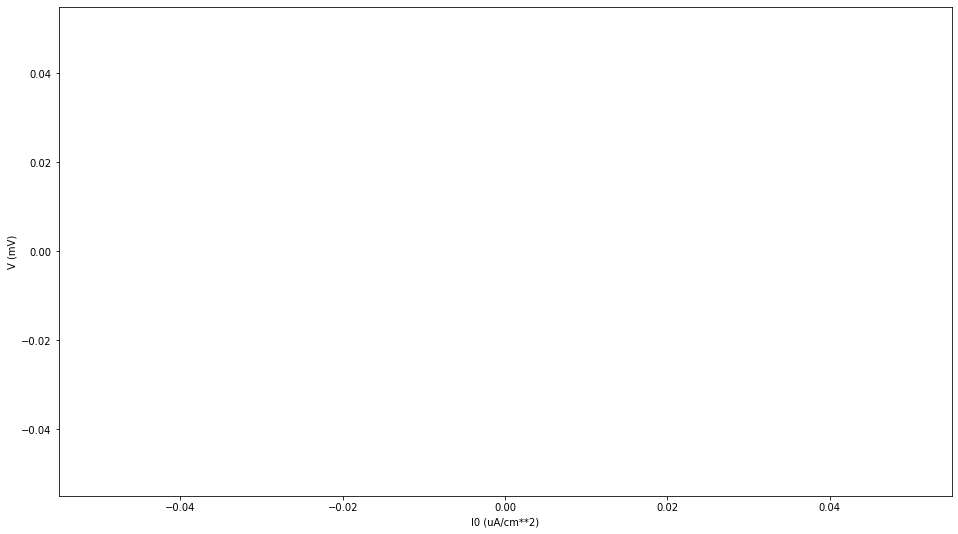

In [ ]:
defaultclock.dt = 0.01*ms
N=900
morpho = Cylinder(length=10*cm, diameter=2*238*um, n=N, type='axon')

El = 10.5995*mV
ENa = 115*mV
EK = -12*mV
gl = 0.3*msiemens/cm**2
gNa0 = 120*msiemens/cm**2
gK = 36*msiemens/cm**2

# Typical equations
eqs = '''
# The same equations for the whole neuron, but possibly different parameter values
# distributed transmembrane current
Im = gl * (El-v) + gNa * m**3 * h * (ENa-v) + gK * n**4 * (EK-v)+ I : amp/meter**2
I = I0*sin(2*pi*50*Hz * t) : amp/meter**2
I0 : amp/meter**2 # applied current
dm/dt = alpham * (1-m) - betam * m : 1
dn/dt = alphan * (1-n) - betan * n : 1
dh/dt = alphah * (1-h) - betah * h : 1
alpham = (0.1/mV) * 10*mV/exprel((-v+25*mV)/(10*mV))/ms : Hz
betam = 4 * exp(-v/(18*mV))/ms : Hz
alphah = 0.07 * exp(-v/(20*mV))/ms : Hz
betah = 1/(exp((-v+30*mV) / (10*mV)) + 1)/ms : Hz
alphan = (0.01/mV) * 10*mV/exprel((-v+10*mV)/(10*mV))/ms : Hz
betan = 0.125*exp(-v/(80*mV))/ms : Hz
gNa : siemens/meter**2
#Cm=1*uF/cm**2 : farad/meter**2
v : volt
'''

  
start_scope()
"""
neuron = SpatialNeuron(morphology=morpho, model=eqs, method="exponential_euler",
                        refractory="m > 0.1", threshold="m > 0.1",
                        Cm=1*uF/cm**2, Ri=35.4*ohm*cm)
"""
neuron = NeuronGroup(N, model=eqs, threshold="m > 0.5",
                    refractory="m > 0.4", method='exponential_euler')

neuron.v = 0*mV
neuron.h = 1
neuron.m = 0
neuron.n = .5
neuron.I0 = linspace(1.732 * uA/cm**2, 1.736 * uA/cm**2, N)
neuron.gNa = gNa0


##init_time = 1*second
#run(init_time, report='text')# we discard the first spikes

states = StateMonitor(neuron, "v", record=True, when='start')
spikes = SpikeMonitor(neuron)
run(1*second, report='text')

# Get the values of Vr and w for each spike
I0 = neuron.I0[spikes.i]
V = states.v[spikes.i, int_((spikes.t-init_time)/defaultclock.dt)]

plt.figure(figsize=(16,9))
plt.scatter(I0 / uA/cm**2, V / mV, marker=".", color="k", linewidths=0.1)
plt.xlabel('I0 (uA/cm**2)')
plt.ylabel('V (mV)')
plt.show()



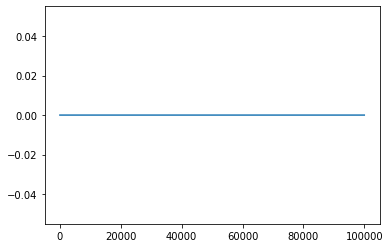

In [ ]:
plot(states.v[99])